In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3
import pytorch_lightning as pl
import torch
from torch import nn
import torchvision.models as models
from pytorch_lightning.metrics import MetricCollection, Accuracy, Precision, Recall, ConfusionMatrix, PrecisionRecallCurve
from pytorch_lightning.callbacks import ModelCheckpoint


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [2]:
class ImEncodeModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        
        self.image_model = models.resnet18(pretrained=True)
        self.image_model.fc = nn.Sequential()
    
    
    def forward(self, input_image):
        encoding = self.image_model(input_image)
        return encoding

In [3]:
class FirstModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        
#         self.image_model = models.resnet18(pretrained=True)
#         self.image_model.fc = nn.Sequential()
#         for name, param in self.image_model.named_parameters():
#             if "layer4.1" not in name:
#                 print(name)
#                 param.requires_grad = False
        self.image_model = ImEncodeModel.load_from_checkpoint(checkpoint_path=\
                                                              '/home/dennis/agriculture/lightning_logs/version_61/checkpoints/epoch=105-step=42717.ckpt')
        
        self.predictor = nn.Sequential(nn.Linear(512, 512),
                                       nn.ReLU(),
                                       nn.Linear(512,256),
                                       nn.ReLU(),
                                       nn.Linear(256,128),
                                       nn.ReLU(),
                                       nn.Linear(128,64),
                                       nn.ReLU(),
                                       nn.Linear(64,32),
                                       nn.ReLU(),
                                       nn.Linear(32,1))

        
        self.train_metrics = MetricCollection({
                                                "tr/acc": Accuracy(threshold = 0.5),
                                                "tr/precision":Precision(is_multiclass = False, threshold = 0.5),
                                                "tr/recall":Recall(is_multiclass = False, threshold = 0.5),
                                                
        })
        self.valid_metrics = MetricCollection({
                                                "val/acc": Accuracy(threshold = 0.5),
                                                "val/precision":Precision(is_multiclass = False, threshold = 0.5),
                                                "val/recall":Recall(is_multiclass = False, threshold = 0.5)
        })
        self.test_metrics = MetricCollection({
                                                "test/acc": Accuracy(threshold = 0.5),
                                                "test/precision":Precision(is_multiclass = False, threshold = 0.5),
                                                "test/recall":Recall(is_multiclass = False, threshold = 0.5)
        })
        

        self.confmat = ConfusionMatrix(num_classes=2, threshold = 0.5)
        self.prc = PrecisionRecallCurve(num_classes = 1)
    
    def loss(self,x,y, weight = None):
        if weight is None:
            return nn.functional.binary_cross_entropy_with_logits(x.squeeze(),y.squeeze())
        else:
            return nn.functional.binary_cross_entropy_with_logits(x.squeeze(),y.squeeze(), weight = weight.squeeze())
    
    def forward(self, healthy_image, unknown_image):
        encoded_healthy_image = self.image_model(healthy_image)#.permute(0,3,1,2))
        encoded_unknown_image = self.image_model(unknown_image)#.permute(0,3,1,2))
        #distance_matrix_line = self.distance_matrix_predictor(torch.cat((encoded_healthy_image, encoded_unknown_image), -1))
        #distance_matrix = torch.einsum("bn,bo->bno", distance_matrix_line, distance_matrix_line)
        #distance = torch.einsum("bi,bij,bj->b", encoded_healthy_image, distance_matrix, encoded_unknown_image)
        #prediction = self.distance_predictor(distance.unsqueeze(-1))
        prediction = self.predictor( encoded_unknown_image)
        return prediction

    def training_step(self, batch, batch_idx):
        prediction = self.forward(batch['healthy image'], batch['unknown image'])

        # reconstruction
        reconstruction_loss = self.loss(prediction, batch['label'], batch['weight'])
        self.log("tr/loss", reconstruction_loss)
        
        self.train_metrics(torch.sigmoid(prediction), batch['label'].squeeze().long())
        self.log_dict(self.train_metrics, on_step=True, on_epoch=True)
        return reconstruction_loss

    def validation_step(self, batch, batch_idx):
        prediction = self.forward(batch['healthy image'], batch['unknown image'])
        # reconstruction
        reconstruction_loss = self.loss(prediction, batch['label'], batch['weight'])
        self.log("val/loss", reconstruction_loss)
        
        self.valid_metrics(torch.sigmoid(prediction), batch['label'].squeeze().long())
        self.log_dict(self.valid_metrics, on_step=False, on_epoch=True)
        
        return reconstruction_loss
    
    def test_step(self, batch, batch_idx):
        
        prediction = self.forward(batch['healthy image'], batch['unknown image'])
        # reconstruction
        reconstruction_loss = self.loss(prediction, batch['label'], batch['weight'])
        self.log("test/loss", reconstruction_loss)
        
        self.test_metrics(torch.sigmoid(prediction), batch['label'].squeeze().long())
        self.log_dict(self.test_metrics, on_step=False, on_epoch=True)
        self.confmat.update(torch.sigmoid(prediction), batch['label'].squeeze().long())
        #print(torch.sigmoid(prediction).shape)
        self.prc.update(torch.sigmoid(prediction).squeeze(), batch['label'].squeeze().long())
        return reconstruction_loss
        

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.000002)

In [4]:
from datamodule import ZeroShotDataModule
dm = ZeroShotDataModule(batch_size = 64, 
                        test_plants = 'all', 
                        train_plants = ['Cherry_(including_sour)', 'Corn_(maize)', 'Grape', 'Peach', 'Pepper,_bell', 'Potato', 'Strawberry', 'Tomato'])
dm.setup()

plants in this dataset: ['Cherry_(including_sour)', 'Corn_(maize)', 'Grape', 'Peach', 'Pepper,_bell', 'Potato', 'Strawberry', 'Tomato']
Cherry_(including_sour), healthy: 597
Cherry_(including_sour), Powdery_mildew: 736
Corn_(maize), Northern_Leaf_Blight: 689
Corn_(maize), healthy: 813
Corn_(maize), Common_rust_: 834
Corn_(maize), Cercospora_leaf_spot Gray_leaf_spot: 359
Grape, Esca_(Black_Measles): 968
Grape, Black_rot: 826
Grape, healthy: 296
Grape, Leaf_blight_(Isariopsis_Leaf_Spot): 753
Peach, healthy: 251
Peach, Bacterial_spot: 1607
Pepper,_bell, healthy: 1033
Pepper,_bell, Bacterial_spot: 697
Potato, healthy: 106
Potato, Late_blight: 700
Potato, Early_blight: 700
Strawberry, healthy: 319
Strawberry, Leaf_scorch: 776
Tomato, Septoria_leaf_spot: 1239
Tomato, Leaf_Mold: 666
Tomato, healthy: 1113
Tomato, Spider_mites Two-spotted_spider_mite: 1173
Tomato, Late_blight: 1336
Tomato, Bacterial_spot: 1488
Tomato, Early_blight: 700
Tomato, Tomato_Yellow_Leaf_Curl_Virus: 3749
Tomato, Tomato_

In [5]:
model = FirstModel()

checkpoint_callback = ModelCheckpoint(monitor='val/loss')
trainer = pl.Trainer(gpus = 1, max_epochs = 650, log_every_n_steps=1, fast_dev_run = False, callbacks = checkpoint_callback)
trainer.fit(model, dm)

/home/dennis/klab-localization/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name          | Type                 | Params
-------------------------------------------------------
0 | image_model   | ImEncodeModel        | 11.2 M
1 | predictor     | Sequential           | 437 K 
2 | train_metrics | MetricCollection     | 0     
3 | valid_metrics | MetricCollection     | 0     
4 | test_metrics  | MetricCollection     | 0     
5 | confmat       | ConfusionMatrix      | 0     
6 | prc           | PrecisionRecallCurve | 0     
-------------------------------------------------------
11.6 M    Trainable params
0         Non-trainable params
11.6 M    Total params
4

1

In [6]:
model = FirstModel.load_from_checkpoint(checkpoint_path =checkpoint_callback.best_model_path) 


/home/dennis/klab-localization/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [7]:
print(checkpoint_callback.best_model_path)

/home/dennis/agriculture/lightning_logs/version_91/checkpoints/epoch=134-step=54404.ckpt


In [8]:
res = trainer.test(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


/home/dennis/klab-localization/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.9401296973228455,
 'test/loss': 0.008752932772040367,
 'test/precision': 0.9875565767288208,
 'test/recall': 0.7144026160240173}
--------------------------------------------------------------------------------


tensor([[4780.,   11.],
        [ 349.,  873.]], device='cuda:0')


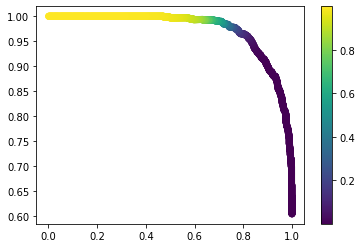

In [9]:
print(model.confmat.compute())
precision, recall, thresholds = model.prc.compute()
import matplotlib.pyplot as plt
#print(thresholds)
plt.scatter(recall[:-1].cpu().numpy(), precision[:-1].cpu().numpy(), c= thresholds.cpu().numpy().squeeze())
plt.colorbar()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Apple



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.6150627732276917,
 'test/loss': 1.236096739768982,
 'test/precision': 0.9701492786407471,
 'test/recall': 0.2631579041481018}
--------------------------------------------------------------------------------
tensor([[192.,  39.],
        [ 13., 234.]], device='cuda:0')


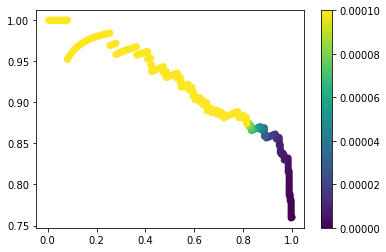

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Cherry_(including_sour)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 1.0,
 'test/loss': 0.0009631194407120347,
 'test/precision': 1.0,
 'test/recall': 1.0}
--------------------------------------------------------------------------------
tensor([[157.,   1.],
        [  0., 128.]], device='cuda:0')


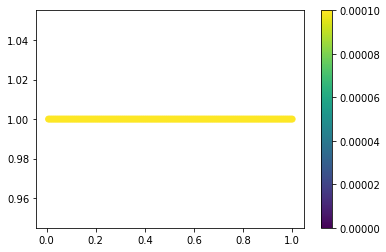

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Corn_(maize)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.9913644194602966,
 'test/loss': 0.009995503351092339,
 'test/precision': 1.0,
 'test/recall': 0.9714285731315613}
--------------------------------------------------------------------------------
tensor([[399.,   5.],
        [  0., 175.]], device='cuda:0')


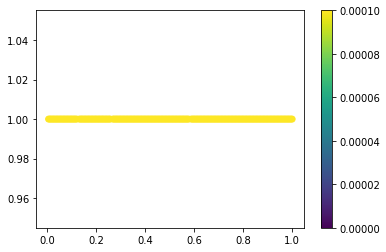

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Grape



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 1.0,
 'test/loss': 0.0012004243908450007,
 'test/precision': 1.0,
 'test/recall': 1.0}
--------------------------------------------------------------------------------
tensor([[545.,   2.],
        [  0.,  64.]], device='cuda:0')


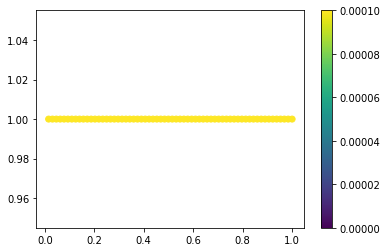

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Peach



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.9900000095367432,
 'test/loss': 0.03287141025066376,
 'test/precision': 1.0,
 'test/recall': 0.9272727370262146}
--------------------------------------------------------------------------------
tensor([[322.,  23.],
        [  0.,  55.]], device='cuda:0')


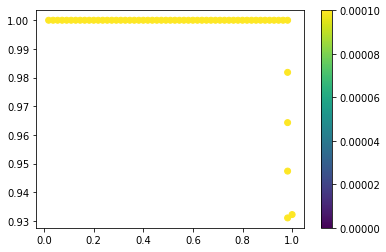

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Pepper,_bell



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.9543010592460632,
 'test/loss': 0.06588388234376907,
 'test/precision': 1.0,
 'test/recall': 0.9234234094619751}
--------------------------------------------------------------------------------
tensor([[139.,  11.],
        [  0., 222.]], device='cuda:0')


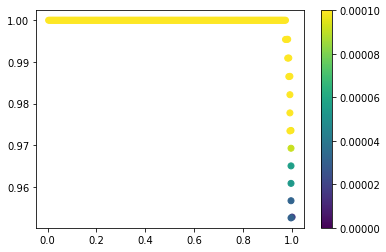

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Potato



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.9938080310821533,
 'test/loss': 0.013919886201620102,
 'test/precision': 1.0,
 'test/recall': 0.9130434989929199}
--------------------------------------------------------------------------------
tensor([[293.,   7.],
        [  0.,  23.]], device='cuda:0')


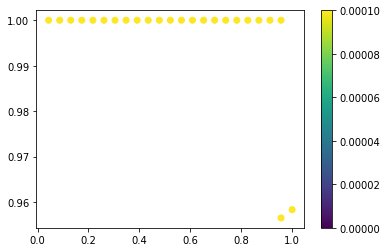

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Strawberry



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.9788135886192322,
 'test/loss': 0.04938802868127823,
 'test/precision': 1.0,
 'test/recall': 0.9275362491607666}
--------------------------------------------------------------------------------
tensor([[167.,   0.],
        [  0.,  69.]], device='cuda:0')


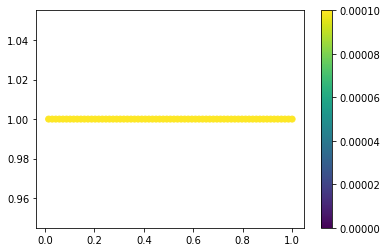

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Tomato



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.9475806355476379,
 'test/loss': 0.15996016561985016,
 'test/precision': 0.9210526347160339,
 'test/recall': 0.4393305480480194}
--------------------------------------------------------------------------------
tensor([[2.1870e+03, 3.0200e+02],
        [1.0000e+00, 2.3800e+02]], device='cuda:0')


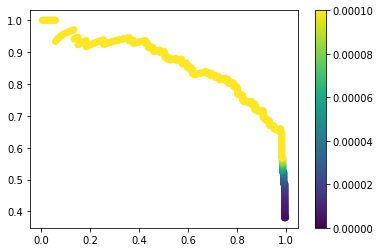

In [10]:
for (plant_name, dl) in dm.test_indiv_plants_dataloaders().items():
    model.confmat.reset()
    model.prc.reset()
#     if plant_name == "Apple":
#         model.confmat.threshold = 0.004
#         #model.recall.threshold = 0.004
#     else:
#         model.confmat.threshold = 0.5
    model.confmat.threshold = 0.00001
    print(plant_name)
    res = trainer.test(model, test_dataloaders= dl)
    print(model.confmat.compute())
    precision, recall, thresholds = model.prc.compute()
    plt.scatter(recall[:-1].cpu().numpy(), precision[:-1].cpu().numpy(), c= thresholds.cpu().numpy().squeeze(), vmin = 0, vmax = 0.0001)
    plt.colorbar()
    plt.show()
    

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Apple



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.6150627732276917,
 'test/loss': 1.236096739768982,
 'test/precision': 0.9701492786407471,
 'test/recall': 0.2631579041481018}
--------------------------------------------------------------------------------
tensor([[201.,  30.],
        [ 43., 204.]], device='cuda:0')


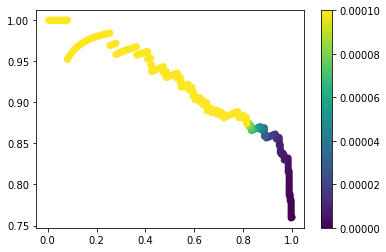

In [11]:
import numpy as np
for (plant_name, dl) in dm.test_indiv_plants_dataloaders().items():
    if plant_name != "Apple":
        continue
    model.confmat.reset()
    model.prc.reset()
#     if plant_name == "Apple":
#         model.confmat.threshold = 0.004
#         #model.recall.threshold = 0.004
#     else:
#         model.confmat.threshold = 0.5
    model.confmat.threshold = 0.00008
    print(plant_name)
    res = trainer.test(model, test_dataloaders= dl)
    cm = model.confmat.compute()
    print(cm)
    precision, recall, thresholds = model.prc.compute()
    plt.scatter(recall[:-1].cpu().numpy(), precision[:-1].cpu().numpy(), c= thresholds.cpu().numpy().squeeze(), vmin = 0, vmax = 0.0001)
    plt.colorbar()
    plt.show()


results_dict = {
    "confusion matrix": cm.cpu().detach().numpy(),
    "model path": checkpoint_callback.best_model_path
}
np.save("initial_model_results/healthy_image_branch_ablation.npy", results_dict)